imports

In [1]:
import pandas as pd
import pyarrow


# Reading in data

silver data

In [2]:
# read
silver_test = pd.read_parquet('data/test-00000-of-00001.parquet')
silver_labels = silver_test["ner_tags"][:1000]
silver_labels.drop(silver_labels.index[68], inplace=True)

silver_labels.head()

0    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, ...
1           [0, 1, 2, 0, 1, 2, 0, 0, 3, 4, 0, 0, 0, 0]
2                                            [3, 4, 4]
3                       [0, 5, 6, 6, 0, 0, 0, 0, 0, 0]
4                                [1, 2, 2, 0, 3, 4, 0]
Name: ner_tags, dtype: object

gold data

In [3]:
gold_eng = pd.read_csv("data/gold_eng_donee.csv", sep=";")
columns_to_drop = ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']

gold_eng


,Labels,Sentences
0,"[0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,5,0,0,0]","[ ""Shortly"", ""afterward"", "","", ""an"", ""encourag..."
1,"[0,1,2,0,1,2,0,0,0,0,0,0,0,0]","[ "":"", ""Kanye"", ""West"", ""featuring"", ""Jamie"", ..."
2,"[3,4,4]","[ ""Blacktown"", ""railway"", ""station"" ]"
3,"[0,0,0,0,0,0,1,0,0,0]","[ ""''"", ""Mycalesis"", ""perseus"", ""lalassis"", ""'..."
4,"[1,2,2,0,0,0,0]","[ ""Jonny"", ""Lee"", ""Miller"", ""-"", ""Eli"", ""Stone..."
...,...,...
994,"[0,0,0,0,0,0,0,3,4,4,4,4,0,0,3,4,4,4,0]","[ ""After"", ""graduation"", ""in"", ""1946"", "","", ""h..."
995,"[0,1,2,0,0]","[ ""''"", ""Admiral"", ""P"", ""''"", ""'"" ]"
996,"[0,0,0,0,0,0,5,0,5,0]","[ ""In"", ""1853"", ""his"", ""family"", ""moved"", ""to""..."
997,"[0,0,0,0,3,4,4,0,0]","[ ""She"", ""Loves"", ""You"", ""("", ""The"", ""Twilight..."


converting to list of list

In [4]:
gold_words = gold_eng["Sentences"].values.tolist()
gold_labels = gold_eng["Labels"].values.tolist()


In [5]:
silver_labels_list=[(string_list).tolist() for string_list in silver_labels]
gold_labels_list=[eval(string_list) for string_list in gold_labels]
gold_word_list = [eval(string_list) for string_list in gold_words]


# preprocessing the data

In [6]:
from transformers import AutoTokenizer, Trainer

model_checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [7]:
import pandas as pd
label_all_tokens = True

In [8]:
def tokenize_and_align_labels(sentences, tags, tokenizer):
    tokenized_inputs = tokenizer(sentences, truncation=True, is_split_into_words=True, padding=True)

    aligned_labels = []
    for i, label in enumerate(pd.Series(tags)):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        aligned_labels.append(label_ids)

    tokenized_inputs["labels"] = aligned_labels
    return tokenized_inputs.data

In [9]:
tokenized_gold_data = tokenize_and_align_labels(gold_word_list, gold_labels_list, tokenizer)
tokenized_silver_data = tokenize_and_align_labels(gold_word_list, silver_labels_list, tokenizer)

In [10]:
tokenized_silver_data.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])

In [11]:
from datasets import Dataset

In [12]:
gold_dataset = Dataset.from_dict({
    'id': range(len(tokenized_gold_data['input_ids'])),
    'input_ids': tokenized_gold_data['input_ids'],
    'attention_mask': tokenized_gold_data['attention_mask'],
    'labels': tokenized_gold_data['labels']
})

silver_dataset = Dataset.from_dict({
    'id': range(len(tokenized_silver_data['input_ids'])),
    'input_ids': tokenized_silver_data['input_ids'],
    'attention_mask': tokenized_silver_data['attention_mask'],
    'labels': tokenized_silver_data['labels']
})



import pickle

# Save gold_dataset
with open('mbert_eng_gold_gold_dataset.pickle', 'wb') as f:
    pickle.dump(gold_dataset, f)

# Save silver_dataset
with open('mbert_eng_gold_silver_dataset.pickle', 'wb') as f:
    pickle.dump(silver_dataset, f)

# Quality checking lengths of the annotations

In [13]:
# Check if lengths are equal and aligned
lengths_equal = all(len(gold_labels) == len(sentences) for gold_labels, sentences in zip(gold_labels_list, gold_word_list))

print("Are lengths equal and aligned:", lengths_equal)

Are lengths equal and aligned: True


In [14]:
silver_labels_list = [(string_list).tolist() for string_list in silver_labels]
gold_labels_list = [eval(string_list) for string_list in gold_labels]
gold_word_list = [eval(string_list) for string_list in gold_words]

# Check if all lists have the same length at each index
for i in range(min(len(silver_labels_list), len(gold_labels_list), len(gold_word_list))):
    silver_len = len(silver_labels_list[i])
    gold_len = len(gold_labels_list[i])
    word_len = len(gold_word_list[i])
    
    if silver_len != gold_len or silver_len != word_len:
        print(f"At index {i}: Silver labels length = {silver_len}, Gold labels length = {gold_len}, Gold words length = {word_len}")
        


# using test data on saved model

In [15]:
#gold_dataset

In [16]:
from transformers import AutoTokenizer, Trainer,AutoModelForTokenClassification

In [17]:
loaded_model = AutoModelForTokenClassification.from_pretrained("data/baseline")

In [18]:
loaded_model.to("cuda:0")

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [19]:
#loaded_model

In [20]:
#import pickle

#with open('bert_pl_gold_gold_dataset.pickle','rb') as f: gold_dataset = pickle.load(f)

In [21]:
loaded_model.device.type

'cuda'

In [22]:
trainer = Trainer(model = loaded_model)

Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [23]:
trainer.evaluate(gold_dataset)

{'eval_loss': 1.9115866422653198,
 'eval_runtime': 3.0647,
 'eval_samples_per_second': 325.975,
 'eval_steps_per_second': 40.788}

In [24]:
trainer.predict(gold_dataset)

PredictionOutput(predictions=array([[[ 8.148866  , -2.2450225 , -2.3864386 , ..., -1.2124825 ,
         -1.4744921 , -1.4889894 ],
        [ 9.430927  , -2.415362  , -1.8564869 , ..., -1.1570425 ,
         -1.8409264 , -1.3425988 ],
        [ 9.369586  , -2.669233  , -1.5854046 , ..., -0.7505755 ,
         -2.0240026 , -1.0484583 ],
        ...,
        [ 8.991158  , -1.8880312 , -1.4882517 , ..., -1.3165741 ,
         -1.5680077 , -1.569471  ],
        [ 8.800995  , -1.9934391 , -2.1819959 , ..., -1.3789847 ,
         -1.3181232 , -1.6756682 ],
        [ 8.10932   , -2.1393607 , -2.0400798 , ..., -1.1016438 ,
         -0.57474816, -1.3890669 ]],

       [[ 9.157242  , -2.2577646 , -1.8614348 , ..., -1.0498216 ,
         -2.2351818 , -1.9558831 ],
        [ 9.613338  , -2.1132996 , -1.7163129 , ..., -1.0147057 ,
         -2.339572  , -1.7289554 ],
        [-2.3934398 ,  8.256117  , -0.81239945, ..., -1.9488174 ,
         -2.1962483 , -2.821481  ],
        ...,
        [ 9.240855  , -2.

In [25]:
loaded_model.to("cuda:0")

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [26]:
import numpy as np


In [27]:
id2label = {0: '0',
            1: 'B-PER', 
            2: 'I-PER',
            3: 'B-ORG',
            4: 'I-ORG',
            5: 'B-LOC',
            6: 'I-LOC'
           }

In [28]:
label2id = {label: id for id, label in id2label.items()}

In [29]:
label_names = list(label2id.keys())

In [30]:
from datasets import load_metric

In [31]:
metric = load_metric("seqeval")

/tmp/ipykernel_26262/152412463.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")
/home/jhag/.local/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [32]:
predictions, labels, metrics = trainer.predict(gold_dataset)
predictions = np.argmax(predictions, axis=2)

true_predictions = [
    [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_names[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results = metric.compute(predictions=true_predictions, references=true_labels)
results

/home/jhag/.local/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 0 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


{'LOC': {'precision': 0.5389541088580576,
  'recall': 0.5934195064629847,
  'f1': 0.564876957494407,
  'number': 851},
 'ORG': {'precision': 0.4979310344827586,
  'recall': 0.66728280961183,
  'f1': 0.5703001579778831,
  'number': 541},
 'PER': {'precision': 0.8293370944992948,
  'recall': 0.735,
  'f1': 0.779324055666004,
  'number': 800},
 '_': {'precision': 0.5593451568894953,
  'recall': 0.5304010349288486,
  'f1': 0.5444887118193892,
  'number': 773},
 'overall_precision': 0.6005154639175257,
 'overall_recall': 0.6286677908937606,
 'overall_f1': 0.6142692371066074,
 'overall_accuracy': 0.7764871524111229}

In [33]:
from sklearn.metrics import confusion_matrix

In [34]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Flatten true labels and predicted labels
true_labels_flat = [label for sublist in true_labels for label in sublist]
predicted_labels_flat = [label for sublist in true_predictions for label in sublist]

# Get unique labels
unique_labels = sorted(list(set(true_labels_flat + predicted_labels_flat)))

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels_flat, predicted_labels_flat, labels=unique_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[4966  274  228   47  352  577  248]
 [  39  588   31   10  127   35   20]
 [  57   29  394    6    7   40    5]
 [  82   16   31  635    5    5   26]
 [  15   17    4    1  384   52   13]
 [  10    1   16    0   38  772   13]
 [  10    0    0    4    8   41 1085]]


<Figure size 1000x800 with 0 Axes>

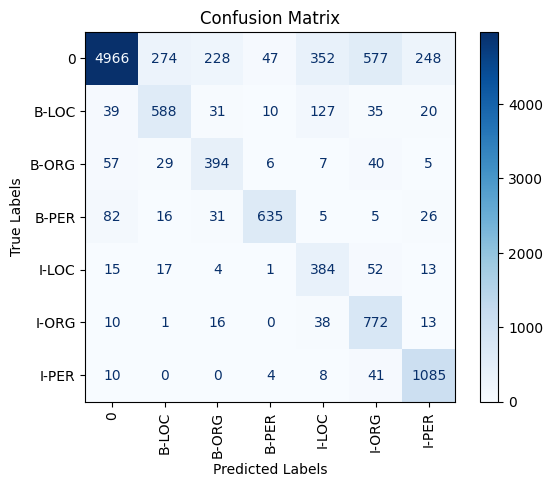

In [35]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay

# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=unique_labels)
disp = disp.plot(cmap=plt.cm.Blues, values_format='d', xticks_rotation='vertical')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig("confusion_gold_bert")
plt.show()


<Figure size 1000x800 with 0 Axes>

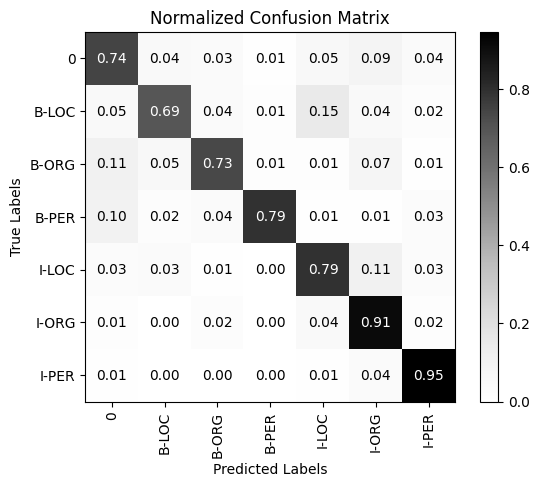

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import normalize

# Assuming cf_matrix and unique_labels are already defined
# Normalize the confusion matrix by rows
cf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix_normalized, display_labels=unique_labels)
disp = disp.plot(cmap=plt.cm.Greys, values_format='.2f', xticks_rotation='vertical')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.savefig("confusion_gold_bert_eng_normalized")
plt.show()

In [37]:
for i in range(len(true_predictions)):
    print("Example", i+1)
    print("Predicted:", true_predictions[i])
    print("Real:", true_labels[i], "\n")
       

Example 1
Predicted: ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'B-LOC', '0', '0', '0', '0', 'B-LOC', 'B-LOC', '0', '0', '0']
Real: ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'B-LOC', '0', '0', '0', '0', 'B-LOC', 'B-LOC', '0', '0', '0'] 

Example 2
Predicted: ['0', 'B-PER', 'B-PER', 'B-PER', 'I-PER', '0', 'B-PER', 'I-PER', 'I-PER', '0', '0', '0', 'B-ORG', 'I-ORG', 'I-ORG', '0', '0', '0', '0', '0']
Real: ['0', 'B-PER', 'B-PER', 'B-PER', 'I-PER', '0', 'B-PER', 'I-PER', 'I-PER', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'] 

Example 3
Predicted: ['B-ORG', 'B-ORG', 'I-ORG', 'I-ORG']
Real: ['B-ORG', 'B-ORG', 'I-ORG', 'I-ORG'] 

Example 4
Predicted: ['0', '0', 'B-LOC', 'B-LOC', 'B-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Real: ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'B-PER', 'B-PER', 'B-PER', 'B-PER', '0', '0', '0'] 

Example 5
Predicted: ['B-PER', 'B-PER', 

In [38]:
for i in range(len(true_predictions)):
    if true_predictions[i] != true_labels[i]:
        print("Example", i+1)
        print("Predicted:", true_predictions[i])
        print("Real:", true_labels[i])
   


Example 2
Predicted: ['0', 'B-PER', 'B-PER', 'B-PER', 'I-PER', '0', 'B-PER', 'I-PER', 'I-PER', '0', '0', '0', 'B-ORG', 'I-ORG', 'I-ORG', '0', '0', '0', '0', '0']
Real: ['0', 'B-PER', 'B-PER', 'B-PER', 'I-PER', '0', 'B-PER', 'I-PER', 'I-PER', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Example 4
Predicted: ['0', '0', 'B-LOC', 'B-LOC', 'B-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Real: ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'B-PER', 'B-PER', 'B-PER', 'B-PER', '0', '0', '0']
Example 5
Predicted: ['B-PER', 'B-PER', 'I-PER', 'I-PER', '0', 'B-PER', 'I-PER', '0', '0']
Real: ['B-PER', 'B-PER', 'I-PER', 'I-PER', '0', '0', '0', '0', '0']
Example 6
Predicted: ['B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'I-LOC', 'I-LOC', 'I-LOC', '0', '0', '0', '0', '0']
Real: ['0', '0', '0', '0', '0', '0', '0', '0', '0', 'B-PER', 'B-PER', 'B-PER']
Example 7
Predicted: ['B-ORG', 'B-ORG', 'I-ORG', 'I-ORG', 'I-ORG

Example 826
Predicted: ['0', '0', 'B-LOC', 'B-LOC', 'B-LOC', 'I-LOC', 'I-LOC', 'I-LOC', '0', '0', '0', '0']
Real: ['0', '0', 'B-LOC', 'B-LOC', 'B-LOC', 'I-LOC', '0', '0', '0', '0', '0', '0']
Example 827
Predicted: ['B-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', '0', '0', '0']
Real: ['B-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', '0', '0']
Example 828
Predicted: ['B-ORG', 'B-ORG', 'B-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', '0', '0']
Real: ['0', '0', '0', '0', '0', '0', '0', 'B-PER', 'I-PER', '0', '0', '0', '0']
Example 829
Predicted: ['B-LOC', 'I-LOC', 'I-LOC', 'I-LOC']
Real: ['B-LOC', 'I-LOC', '0', 'B-LOC']
Example 832
Predicted: ['0', '0', '0', 'B-PER', 'I-PER', 'I-PER', '0', 'B-ORG', 'B-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', '0', '0', '0', '0', '0']
Real: ['0', '0', '0', 'B-PER', 'I-PER', 'I-PER', '0', 'B-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', '0', '0', '0', '0', '0']
Example 835
Predicted: ['B-PER', 'I-PER',